In [6]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from time import time
import matplotlib.pyplot as plt

# set seed for the random number generations (to be able to replicate the results)
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [2]:
# loading and transforming the data

# transform
transform = transforms.Compose([transforms.ToTensor(), #transforms image into colour matrices with values ranging from 0 -1 (becomes a Torch Tensor)
                              transforms.Normalize((0.5,), (0.5,)), # normalizes tensor
                              ])

# loading the data
trainset = datasets.EMNIST('\Datasets\MNIST\Trainset', download=True, split='letters', train=True, transform=transform)
valset = datasets.EMNIST('\Datasets\MNIST\Valset', download=True, split='letters', train=False, transform=transform)

# creating the batches 
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) 
test_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) 

In [3]:
# defining the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(784,128)
        self.lin2 = nn.Linear(128,64)
        self.lin3 = nn.Linear(64,27)

    def forward(self, x):
        x = x.view(x.shape[0], -1) # transforms input into 2D, keeps batches as 64, infers other value 
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return F.log_softmax(x, dim = 1)
        
model = Net()
print(model)

Net(
  (lin1): Linear(in_features=784, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=27, bias=True)
)


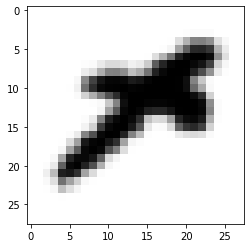

In [8]:
# display one image
images, labels = next(iter(train_loader))
plt.imshow(images[60].numpy().squeeze(), cmap='gray_r')

In [4]:
# defining the optimization method
learning_rate = 0.003
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [4]:
# setting the image to the correct size
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

# criterion = nn.NLLLoss()
# logps = model(images) #log probabilities
# loss = criterion(logps, labels) #calculate the NLL loss

In [7]:
# # core training process (NN iterates over the training set and updates the weights))
# time0 = time()
# epochs = 15
# for e in range(epochs):
#     running_loss = 0
#     for images, labels in train_loader:
#         # Training pass
#         optimizer.zero_grad()
        
#         output = model(images)
#         loss = criterion(output, labels)
        
#         #This is where the model learns by backpropagating
#         loss.backward()
        
#         #And optimizes its weights here
#         optimizer.step()
        
#         running_loss += loss.item()
#     else:
#         print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))
# print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 1.36163492783522
Epoch 1 - Training loss: 0.6907414230475059
Epoch 2 - Training loss: 0.5216275825867286
Epoch 3 - Training loss: 0.44667644774302456
Epoch 4 - Training loss: 0.39697610853192133
Epoch 5 - Training loss: 0.36529207745423686
Epoch 6 - Training loss: 0.3419739656494214
Epoch 7 - Training loss: 0.3223865580253112
Epoch 8 - Training loss: 0.30568636211447225
Epoch 9 - Training loss: 0.2932727290422488
Epoch 10 - Training loss: 0.28056044661463836
Epoch 11 - Training loss: 0.27094381493253583
Epoch 12 - Training loss: 0.2621460666335546
Epoch 13 - Training loss: 0.25346044551485625
Epoch 14 - Training loss: 0.2477346423249214

Training Time (in minutes) = 18.209012258052827


In [8]:
# correct_count, all_count = 0, 0
# for images,labels in test_loader:
#   for i in range(len(labels)):
#     img = images[i].view(1, 784)
#     with torch.no_grad():
#         logps = model(img)

    
#     ps = torch.exp(logps)
#     probab = list(ps.numpy()[0])
#     pred_label = probab.index(max(probab))
#     true_label = labels.numpy()[i]
#     if(true_label == pred_label):
#       correct_count += 1
#     all_count += 1

# print("Number Of Images Tested =", all_count)
# print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 20800

Model Accuracy = 0.8979326923076923


In [6]:
# training the neural network
# core training process (NN iterates over the training set and updates the weights))
# time0 = time()
epochs = 15
def train(epochs):
    #for e in range(epochs):
#     time0 = time()
        running_loss = 0
        correct = 0
        for images, labels in train_loader:
            # Training pass
            optimizer.zero_grad() # sets all optimized gradients to zero

            output = model(images)
            
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
            
            #loss 
            loss = F.nll_loss(output, labels)

            #This is where the model learns by backpropagating
            loss.backward()

            #And optimizes its weights here
            optimizer.step()

            running_loss += loss.item()
        else: 
            print("Epoch {} - Training loss: {:.4f} Train Accuracy: ({:.2f}%)".format(
                i+1, running_loss/len(train_loader),
                100. * correct / len(train_loader.dataset)))
#     print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [7]:
test_losses = []
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for images, labels in test_loader:
      output = model(images)
      test_loss += F.nll_loss(output, labels, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(labels.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print("Test los: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
# test()

In [8]:
time0 = time()
test()
for i in range(epochs):
  train(i)
  test()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

C:\Users\Lina_\anaconda3\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test los: 3.2989, Accuracy: 897/20800 (4.31%)
Epoch 1 - Training loss: 1.3630 Train Accuracy: (60.77%)
Test los: 0.8366, Accuracy: 15703/20800 (75.50%)
Epoch 2 - Training loss: 0.6929 Train Accuracy: (79.41%)
Test los: 0.5930, Accuracy: 17153/20800 (82.47%)
Epoch 3 - Training loss: 0.5160 Train Accuracy: (84.17%)
Test los: 0.4864, Accuracy: 17693/20800 (85.06%)
Epoch 4 - Training loss: 0.4346 Train Accuracy: (86.54%)
Test los: 0.4560, Accuracy: 17922/20800 (86.16%)
Epoch 5 - Training loss: 0.3892 Train Accuracy: (87.83%)
Test los: 0.4218, Accuracy: 18126/20800 (87.14%)
Epoch 6 - Training loss: 0.3586 Train Accuracy: (88.68%)
Test los: 0.3839, Accuracy: 18367/20800 (88.30%)
Epoch 7 - Training loss: 0.3362 Train Accuracy: (89.38%)
Test los: 0.3721, Accuracy: 18443/20800 (88.67%)
Epoch 8 - Training loss: 0.3172 Train Accuracy: (89.90%)
Test los: 0.3619, Accuracy: 18470/20800 (88.80%)
Epoch 9 - Training loss: 0.3020 Train Accuracy: (90.36%)
Test los: 0.3562, Accuracy: 18511/20800 (89.00%)


In [9]:
# save the model
torch.save(model, './01_model.pt') 
#  save the trained model